# Loading modules

If the packages don't load, you'll need to install them using `Pkg.add("module_name")` or from the command line using the `]` to `>pkg` environment.

In [3]:
using NewBioSimulator
# import NewBioSimulator: parse_model

using Combinatorics, SparseArrays, Printf
using Plots

#include("LatticeSimulator-notebook-utils.jl")

## Spatial Predator-Prey Model:

This is for the predator prey model in two dimensions using a hexagonal neighborhood structure.  The rates need to be defined first, passed into the `param` vector, added after each reaction, and listed after the `end` in the `@_def_reactions` macro.  The `@enumerate_with_sclass` takes the skeleton (reactions), a symbol (either `:vonneumann` or `:hexagon`) for the neighborhood structure, then an `Int` for the dimension (1, 2, or 3 for now), and finally the vector of parameters `param`.

Reactions are of two types, pairwise or on-site.  Pairwise reactions look like `A + B --> C + D`, meaning a particle of type `A` interacts with an adjacent particle of type `B`, and each particle changes type to `C` and `D` respectively.  For example, the `F + R --> F + F` predation reaction below denotes a fox `F` eating an adjacent rabbit `R` to produce a new fox.  

On-site reactions have a particle interact with itself only, not with any neighbors.  This looks like `A --> B`.  

In [4]:
using Random

α  = 1.0  # migration rate
β  = 0.02 # rabbit reproduction rate
γ  = 0.02 # predation rate
δ1 = 0.01 # rabbit death rate
δ2 = 0.01 # fox death rate

param = [α, β, γ, δ1, δ2];

skeleton = @def_reactions begin
  R + 0 --> 0 + R, α
  F + 0 --> 0 + F, α
  R + 0 --> R + R, β
  F + R --> F + F, γ
  R --> 0, δ1
  F --> 0, δ2
end α β γ δ1 δ2

model = @enumerate_with_sclass skeleton :hexagon 2 param ;

Here we generate the initial conditions.  `generate_random_2Dpoints` is a function in the `LatticeSimulator-notebook-utils.jl` file that randomly scatters points within the `(xmin, xmax)` and `(ymin, ymax)` range, with some saturation between 0 and 1.  We then randomly assign a type to each point, then feed the whole mess into the `SLattice` function to generate the initial lattice.  Note we need to specify the number of types, and the neighborhood structure again (note this is `hexagonal`, not `hexagon` here... I'll fix this, eventually).  

In [5]:
Random.seed!(5357)

points = generate_random_2Dpoints((0, 9), (0, 9), 0.8)
ptypes = rand(1:2, size(points, 2)) # prey - 1, predator - 2
state = SLattice(points, ptypes, model, number_types=2, nbhood = :hexagonal);

Finally we call the `simulate` function with the `Direct()` tag telling it to use Gillespie's stochastic simulation algorithm.  The `150.0` is the time that the simulation runs for.  This is the same units of time used for the rates.

In [6]:
results = simulate(state, model, Direct(), 150.0, HasRates) ; 

And we plot, using the `hex_config` command in the appendix.  The plotting command is called on the output from the `simulate` function or on the initial condition `state`, the output from the `SLattice` command.

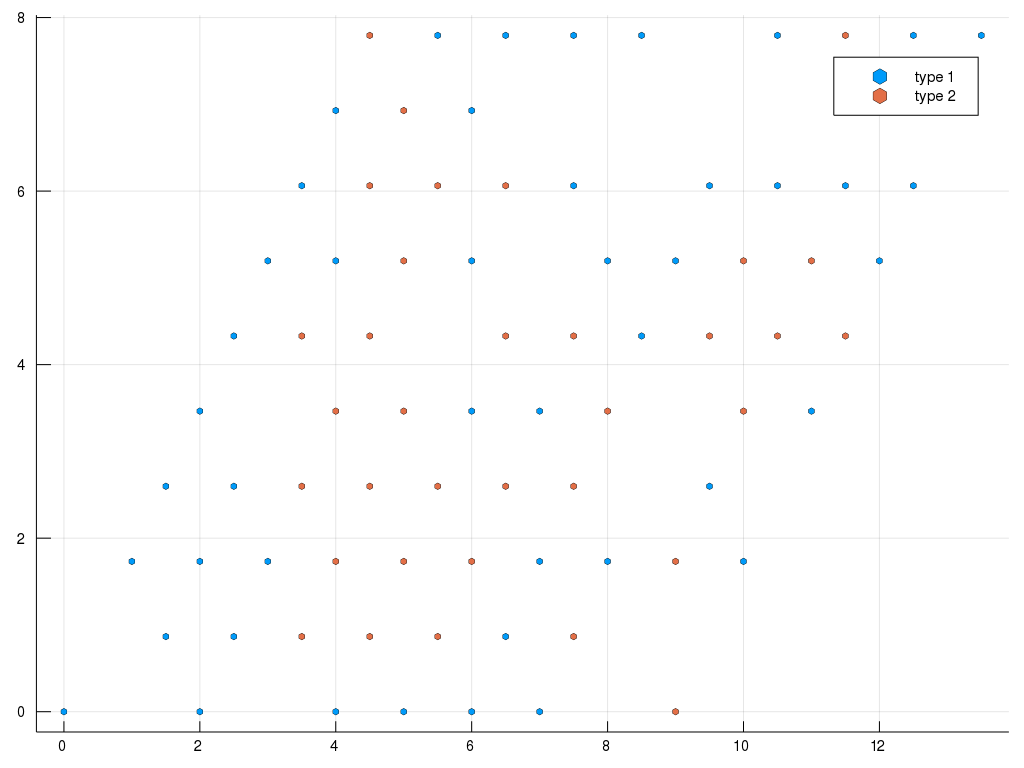

In [7]:
# This is the initial configuration

plot_hex_config(state)

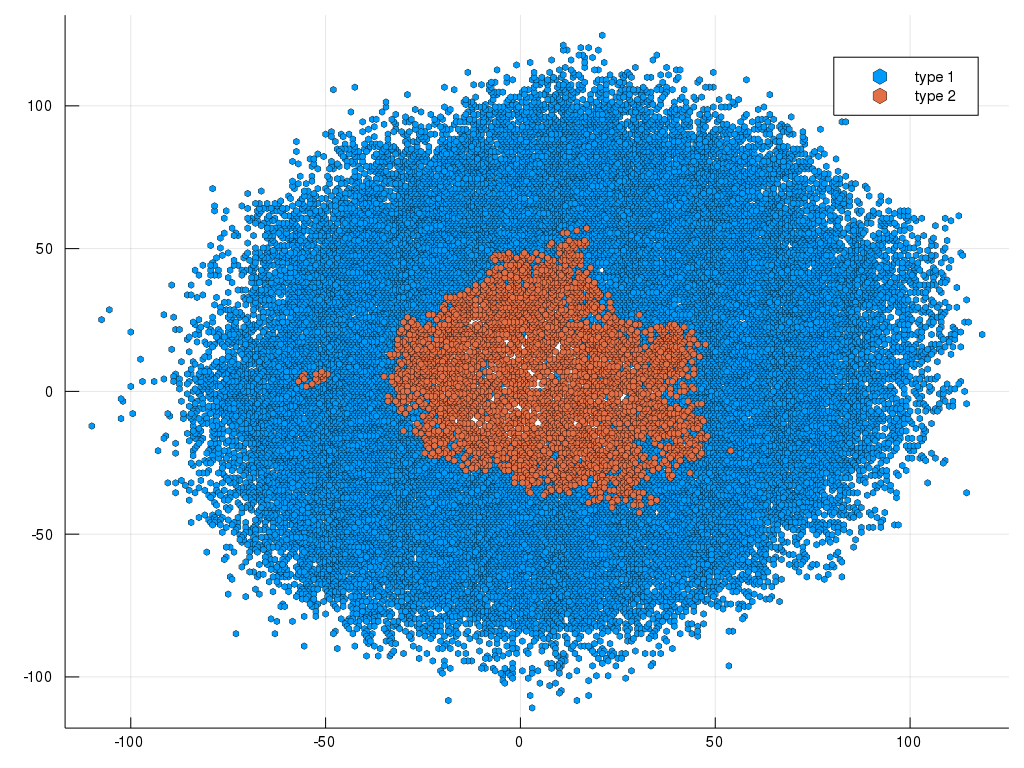

In [8]:
# and this is the final configuration

plot_hex_config(results)

# Explanation of the fields

Most of the complex functions used in LatticeSimulator output objects.  Each object has a set of fields, which can be accessed by `object_name.field_name`.  Here is how we display the fields:

In [9]:
fieldnames(SLattice)

(:classes, :k2composition, :composition2k, :label2site, :coord2site, :isactive, :reac2sidx, :lk2sidx, :N, :xclass, :xdiff, :L, :K, :dummy_composition)

For some inane reason `fieldnames(results)` will not return the field names for `results` even though it is an object with field names to return.  It's picky and wants the name of the type of object `results` is, hence `SLattice`.  

Fortunately tab-complete comes to the rescue.  In the command line, type

`julia> results.`

and then slam the tab key a few times, it'll print out a list of the different field names eventually.  Same thing works if you're using `IJulia` or some other notebook package.

We'll go through some of the more important fields now.

## Reaction fields

In [10]:
model.reactions

26-element Array{NewBioSimulator.IPSReactionStruct,1}:
 NewBioSimulator.IPSReactionStruct(true, 2, 1, 1, 2, 1, 1.0)   
 NewBioSimulator.IPSReactionStruct(true, 2, 1, 1, 2, 2, 2.0)   
 NewBioSimulator.IPSReactionStruct(true, 2, 1, 1, 2, 3, 3.0)   
 NewBioSimulator.IPSReactionStruct(true, 2, 1, 1, 2, 4, 4.0)   
 NewBioSimulator.IPSReactionStruct(true, 2, 1, 1, 2, 5, 5.0)   
 NewBioSimulator.IPSReactionStruct(true, 2, 1, 1, 2, 6, 6.0)   
 NewBioSimulator.IPSReactionStruct(true, 3, 1, 1, 3, 7, 1.0)   
 NewBioSimulator.IPSReactionStruct(true, 3, 1, 1, 3, 8, 2.0)   
 NewBioSimulator.IPSReactionStruct(true, 3, 1, 1, 3, 9, 3.0)   
 NewBioSimulator.IPSReactionStruct(true, 3, 1, 1, 3, 10, 4.0)  
 NewBioSimulator.IPSReactionStruct(true, 3, 1, 1, 3, 11, 5.0)  
 NewBioSimulator.IPSReactionStruct(true, 3, 1, 1, 3, 12, 6.0)  
 NewBioSimulator.IPSReactionStruct(true, 2, 1, 2, 2, 1, 0.02)  
 NewBioSimulator.IPSReactionStruct(true, 2, 1, 2, 2, 2, 0.04)  
 NewBioSimulator.IPSReactionStruct(true, 2, 1, 2,

These are the different reactions that get fed into the simulator.  Each one is a different reaction, for example

In [11]:
model.reactions[17]

NewBioSimulator.IPSReactionStruct(true, 2, 1, 2, 2, 5, 0.1)

is the 17th one.  The `Boolean` `true` denotes that the reaction is pairwise.  `2, 1, 2, 2` means a particle of type `2` (prey) interacts with an adjacent particle of type `1` (open site) to produce a particle of type `2` on that open site, while remaining type `2` itself.  This matches with the `Prey + 0 --> Prey + Prey` reaction diagram.

The second to last field `5` denotes that this reaction channel points to sample class `5`, see the document again for an idea of what that looks like (note the order might not be the same as it is in the doc... sample class `5` should be a rabbit surrounded by 5 open sites).  Finally the last float is the rate at which the reaction occurs, so the base rate of $0.02 \times 5$.

## `SLattice` fields

We'll go through some of the fields right now, from most to least useful.  Most of these fields aren't going to be useful at all, some are just placeholders for information the simulation needs to run, like `L` the number of species.

In [12]:
fieldnames(SLattice)

(:classes, :k2composition, :composition2k, :label2site, :coord2site, :isactive, :reac2sidx, :lk2sidx, :N, :xclass, :xdiff, :L, :K, :dummy_composition)

Probably the most useful field for your purposes is `label2site`:

In [13]:
results.label2site

OrderedCollections.OrderedDict{Int64,NewBioSimulator.Site{2,Int64,Hexagonal2D{Int64}}} with 42785 entries:
  1  => 1 / (l, k) = 3, 10 / [1, 6]
  2  => 2 / (l, k) = 3, 6 / [3, 6]
  3  => 3 / (l, k) = 3, 15 / [0, 4]
  4  => 4 / (l, k) = 3, 6 / [1, 5]
  5  => 5 / (l, k) = 1, 3 / [3, 2]
  6  => 6 / (l, k) = 3, 15 / [9, 5]
  7  => 7 / (l, k) = 1, 21 / [2, 9]
  8  => 8 / (l, k) = 1, 21 / [5, 3]
  9  => 9 / (l, k) = 3, 10 / [0, 5]
  10 => 10 / (l, k) = 3, 15 / [7, 0]
  11 => 11 / (l, k) = 3, 28 / [8, 2]
  12 => 12 / (l, k) = 1, 21 / [2, 7]
  13 => 13 / (l, k) = 3, 21 / [7, 9]
  14 => 14 / (l, k) = 1, 15 / [0, 2]
  15 => 15 / (l, k) = 1, 14 / [8, 5]
  16 => 16 / (l, k) = 1, 15 / [0, 6]
  17 => 17 / (l, k) = 1, 6 / [3, 1]
  18 => 18 / (l, k) = 1, 6 / [5, 2]
  19 => 19 / (l, k) = 3, 10 / [0, 9]
  20 => 20 / (l, k) = 3, 15 / [8, 7]
  21 => 21 / (l, k) = 2, 6 / [7, 5]
  22 => 22 / (l, k) = 1, 6 / [2, 2]
  23 => 23 / (l, k) = 3, 3 / [2, 3]
  24 => 24 / (l, k) = 1, 15 / [9, 7]
  25 => 25 / (l, k) = 

Each one of these entries is a particle.  We'll examine the first one in more detail:

In [14]:
particle = results.label2site[1]

1 / (l, k) = 3, 10 / [1, 6]

Surprise surprise, `particle` is itself and object with its own fields.  Yay.  Hitting `Tab` after `particle.` will tell you all the fields associated with it.

In [15]:
particle.coord

2-element StaticArrays.MArray{Tuple{2},Int64,1,2}:
 1
 6

This gives the coordinate of the particle, so it's at x,y = 1,6.  Note for the hexagonal case we're using axial coordinates, see https://www.redblobgames.com/grids/hexagons/#coordinates for more info.

In [16]:
particle.label

1

This is the integer `ID` of the particle.  We use it for keeping track of each particle in the simulation without having to store the coordinates all the time.

In [17]:
particle.neigh

Hexagonal2D{Int64}(NewBioSimulator.Site{2,Int64,Hexagonal2D{Int64}}[4 / (l, k) = 3, 6 / [1, 5], 16 / (l, k) = 1, 15 / [0, 6], 32 / (l, k) = 1, 6 / [0, 7], 38 / (l, k) = 1, 10 / [2, 5], 47 / (l, k) = 3, 6 / [1, 7], 63 / (l, k) = 3, 10 / [2, 6]], 6)

These are the neighbors of particle `1`.  It gives their particle `ID`s as well as the species type and class associated with each neighboring particle.

In [18]:
particle.state.class

10

This is the index for the neighborhood configuration of the particle.  Again see the figures in the document for a better explanation.  It's essentially a number that tells us how many particles of each type are next to `particle`.

In [19]:
particle.state.ptype

3

Finally the good stuff.  This is the species type of `particle`, `1` meaning it is an open site.  

This is probably all the information you'll need out of the `results` object, but please email us if there's something more in depth you'll need.  

# Setting up the initial conditions

I've added the function `generate_bordered_2D_hexgrid` at the bottom of the appendix.  I'll also include some example code for building a crude immunotherapy model inside a bordered region below.

The gist of making the initial condition is to build a vector of tuples 
`points = [ (x1, y1), (x2, y2), (x3, y3),...]` 
and a vector of integers 
`ptype = [ type1, type2, type3,...]`
that tells the function `SLattice` where the coordinates of each particle are to start and what the types of each particle are at the start.  So initial particle `i` has coordinate `points[i]` and type `ptype[i]`.

I've included a more complicated example below, including borders.  When in doubt, just use the `generate_random_2Dpoints` function.

# Immunotherapy nonsense and bordered initial conditions

In [20]:
using BenchmarkTools, Random

α1  = 0.5  # tumor migration rate
α2  = 5.0  # immune cell migration rate

β  = 0.03 # tumor reproduction rate
γ1 = 0.2  # immune cell predation rate
γ2 = 0.0000002 # immune cell recruitment rate
δ1 = 0.01 # tumor death rate
δ2 = 0.01 # immune cell death rate
ω  = 0.00000001 # dummy type


λ = 0.02  # immune cell production rate

κ = 0.2 # fibrosis production rate, ~50% of eating produces fibrosis
Κ = 0.02 # slow porous


param = [α1, α2, β, γ1, γ2, δ1, δ2, λ, ω, κ, Κ];

skeleton = @def_reactions begin
  T + 0 --> 0 + T, α1
  I + 0 --> 0 + I, α2
  T + 0 --> T + T, β
  I + T --> I + 0, γ1
  I + T --> I + I, γ2
  B + 0 --> B + I, λ
  T --> 0, δ1
  I --> 0, δ2
  D + 0 --> D + 0, ω
  F + I --> I + F, Κ
  I + T --> I + F, κ

end α1 α2 β γ1 γ2 δ1 δ2 λ ω κ Κ

model = @enumerate_with_sclass skeleton :hexagon 2 param ;

The above makes a refinement to the predator-prey model to make something approaching a model for a growing tumor interacting with the immune system.  Tumor cells `T` do their normal birth-death-migration thing.  Immune cells `I` are born on the border from `B` cells and also under go death and migration.  These immune cells clear tumor cells on contact, sometimes leaving fibrosis `F` when they're done.  Also the fibrosis cells are slowly porous, can be moved through by the immune cells (though that's probably not exactly right...).  Finally we need to include a dummy reaction for the outer barrier `D` to take part in, otherwise the code will brick itself.  Note `D + 0 --> D + 0` doesn't do anything, hence the dummy reaction.

In [21]:
#Random.seed!(5357)
points = generate_random_2Dpoints((-4, 4), (-4, 4), 0.3)
ptypes = rand(1:1, size(points, 2)) # prey - 1, predator - 2

# add the barriers in
inner_barrier = generate_bordered_2D_hexgrid(150, 0.8)
outer_barrier = generate_bordered_2D_hexgrid(151, 0.8)

# add barrier locations
points = hcat(points, inner_barrier)
points = hcat(points, outer_barrier)

# add barrier types
append!(ptypes, 3 .* ones(length(inner_barrier[1, :])))
append!(ptypes, 4 .* ones(length(outer_barrier[1, :])))
state = SLattice(points, ptypes, model, number_types=5, nbhood = :hexagonal);

This does the standard make a random box of points thing, then builds a barrier around the box.  The inner barrier is for type `3` cells, i.e. `B` cells that produce immune cells `I`, and the outer barrier is for the dummy cells `D`.  We concatenate (`hcat`) the coordinates (`inner_barrier`) of the barriers onto the `points` vector of points, then do the same with the `append!` function for pushing the appropriate number of `3`'s and `4`'s onto the vector of species type integers `ptypes`.  Finally we call the `SLattice` function to build everything.

In [22]:
test = simulate(state, model, Direct(), 150.0, HasRates) ; 

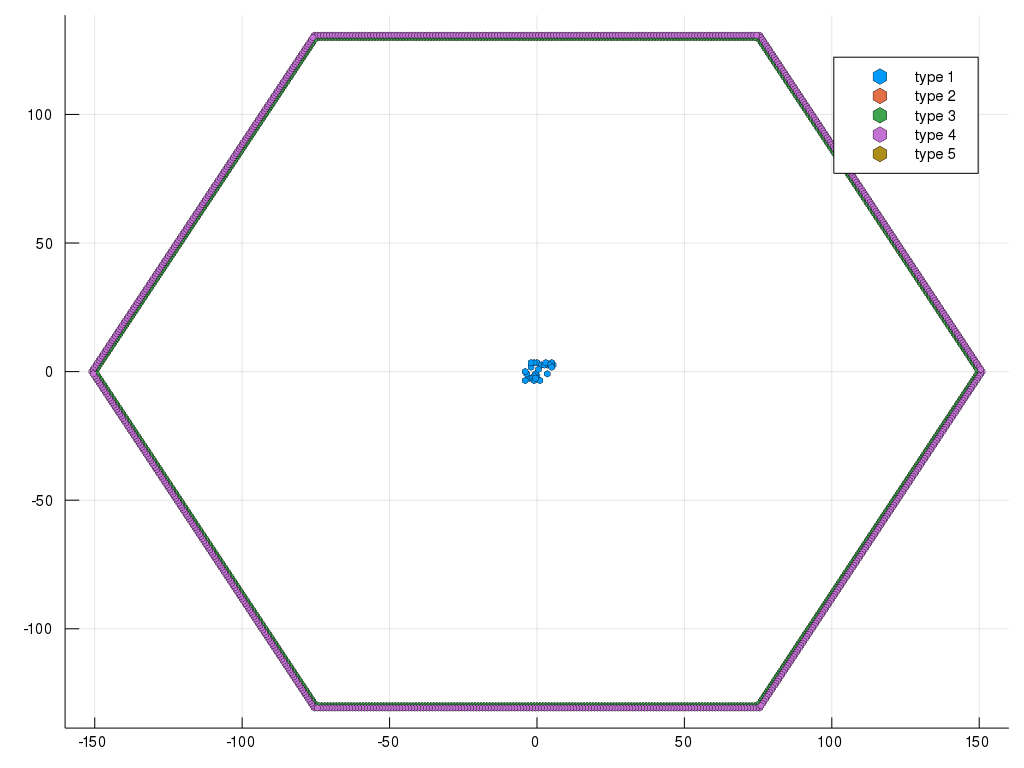

In [23]:
plot_hex_config(state)
# initial conditions

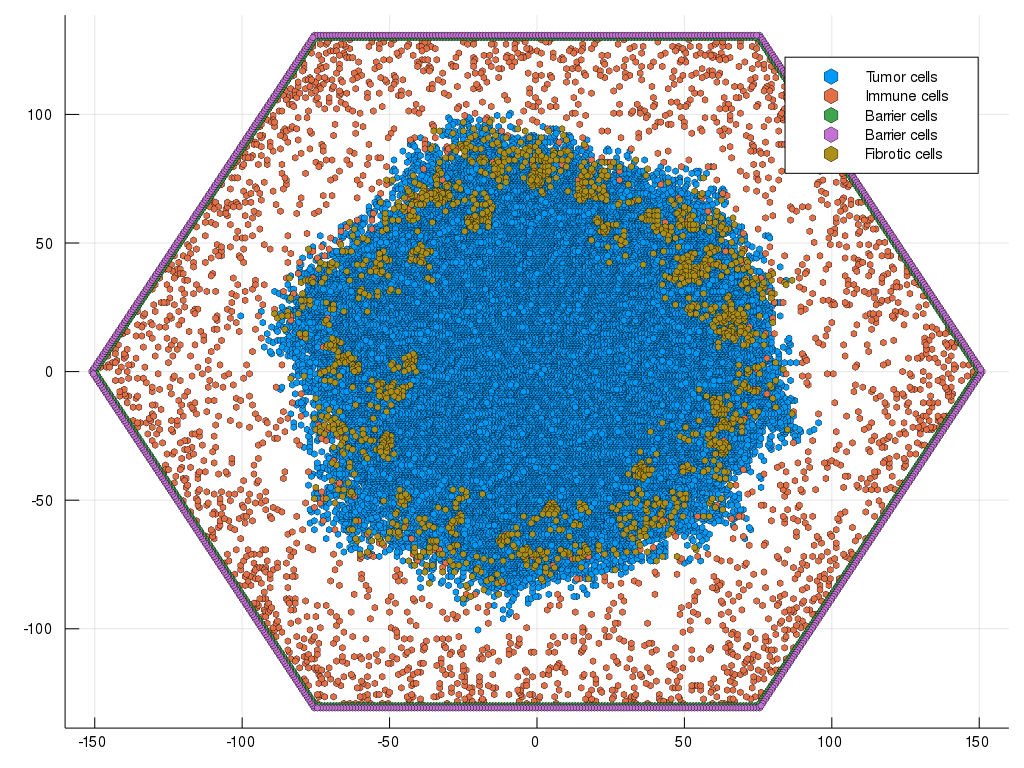

In [24]:
plot_hex_config(test, labels = ["Tumor cells", "Immune cells", "Barrier cells", "Barrier cells", "Fibrotic cells"])
# final output

## Appendix commands


In [25]:
using Plots
gr(fmt = :png, size = (800, 600), dpi = 128)

##### constants #####

# for reproducibility
const CONFIGURATION_SEED = 5357
const SIMULATION_SEED = 1919

# feel free to modify these values for the notebook
MAX_TIME    = 10.0
MAX_POPSIZE = 10_000
MAX_STEPS   = 100

##### function definitions #####

function generate_random_2Dpoints(xlim, ylim, saturation)
    area = (xlim[2] - xlim[1] + 1) * (ylim[2] - ylim[1] + 1)
    N = Int(ceil(area * saturation))

    list = Tuple{Int,Int}[]

    while length(list) < N
        point = (rand(xlim[1]:xlim[2]), rand(ylim[1]:ylim[2]))
        if point ∉ list
            push!(list, point)
        end
    end

    points = zeros(Int64, 2, length(list))
    for i in eachindex(list)
        points[1, i] = list[i][1]
        points[2, i] = list[i][2]
    end

    return points
end

function plot_config(lattice; show_open = false, title = "", xlab = "", ylab = "", labels = nothing)
    # get number of particle types
    L = lattice.L
    
    # set labels if they were omitted
    if labels == nothing
        labels = ["type $(i)" for i in 1:L]
    end
    
    # retrieve the coordinates of every site tracked by the lattice
    sites = collect(values(lattice.coord2site))

    # retrieve the types of every site
    point_types = Vector{Vector{Tuple{Int,Int}}}(L + 1)

    # extract open sites
    point_types[1] = [tuple(site...) for site in filter(y -> get_ptype(y) == 1, sites)]
    
    # extract remaining sites
    for i in 2:L+1
        point_types[i] = [tuple(site...) for site in filter(y -> get_ptype(y) == i, sites)]
    end
    
    # initialize the plot
    p = plot(xlab = xlab, ylab = ylab, title = title)

    # should we display the open sites?
    if show_open
        scatter!(point_types[1], label = "open", color = :white)
    end
    
    # add the normal types
    for i in 2:L+1
        scatter!(point_types[i], label = labels[i - 1])
    end

    return p 
end



function plot_hex_config(lattice; show_open = false, title = "", xlab = "", ylab = "", labels = nothing)
    # get number of particle types
    L = lattice.L
    
    # set labels if they were omitted
    if labels == nothing
        labels = ["type $(i)" for i in 1:L]
    end
    
    # retrieve the coordinates of every site tracked by the lattice
    sites = collect(values(lattice.coord2site))
    
    new_coords = zeros(Float64, 2, length(sites))

    thingx = cos(pi / 3)
    thingy = sin(pi / 3)

    for i in 1:length(sites)
        # janky version, modify the sites by shifting the (x,y) coordinates over by the appropriate amount.  Depends on trig.   Done in axial coordinates
        x = sites[i].coord[1]
        y = sites[i].coord[2]
        #x = coordinates(sites[i])[1]
        #y = coordinates(sites[i])[2]

        new_coords[1, i] = x + thingx * y
        new_coords[2, i] = thingy * y

    end

    # initialize the plot
    p = plot(xlab = xlab, ylab = ylab, title = title)

    # should we display the open sites?
   # if show_open
   #     scatter!(point_types[1], label = "open", color = :white)
   # end
    
    # add the normal types
    #for i in 2:L+1
    for i in 2:L+1
            scatter!( [(site.coord[1] + thingx * site.coord[2], thingy * site.coord[2]) for site in filter(y -> y.state.ptype == i, sites)], label = labels[i - 1], 
            markershape = :hexagon, markersize = 2.5, markerstrokewidth = 0.3)
    end

    return p 
end



function generate_bordered_2D_hexgrid(l, saturation)
    # l is the radius of the hexagon, l >= 2
    
    # number of tiles in a hexagon of length l
    # area = 3 * l * (l + 1) + 1

    # N = Int(ceil(area * saturation)) - (6 * l) # take off the border

    list = Tuple{Int,Int}[]

    # add in the border cells first; there are 6*l of these

    for x in 0:(l - 1)
        point = (- l , x)
        push!(list, point)

        point = (- l + x , l)
        push!(list, point)

        point = (x , l - x) 
        push!(list, point)

        point = (l , - x)
        push!(list, point)

        point = (l - x , - l)
        push!(list, point)

        point = (- x , - l + x)
        push!(list, point)

    end

    # while length(list) < (N + 6 * l)
    #     point = (rand(xlim[1]:xlim[2]), rand(ylim[1]:ylim[2]))
    #     if point ∉ list
    #         push!(list, point)
    #     end
    # end

    points = zeros(Int64, 2, length(list))
    for i in eachindex(list)
        points[1, i] = list[i][1]
        points[2, i] = list[i][2]
    end

    return points
end

generate_bordered_2D_hexgrid (generic function with 1 method)